# Data cleaning

### import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import os
import itertools
from collections import Counter
import re
import string

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
import contractions
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score
from sklearn import metrics

### import data

There are 2 files imported. <br>
train_dt.csv: I will use it to build the model <br>
test_dt.csv: I will use it to apply the model and submit the prediction for competition. <br>

In [2]:
train=pd.read_csv("train_dt.csv")
test=pd.read_csv("test_dt.csv")

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### drop insignfifcant columns

Drop the keyword and location columns. They will not be used further.

In [5]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [6]:
columns_dropped=['keyword', 'location']

In [7]:
train.drop(columns=columns_dropped,inplace=True)

In [8]:
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


### Extract useful features

extract numeric features including: <br>
length of text <br>
number of word tokens <br>
number of upper case characters (will be dropped later) <br>
number of punctuation (will be dropped later) <br>
percentage of upper case characters <br>
percentage of punctuation <br>

extract hashtags from text to find: <br>
number of hashtags (will be dropped later) <br>
percentage of hashtags <br>

In [9]:
punc=string.punctuation

In [10]:
stpwrd = stopwords.words('english')

In [11]:
lemmatizer = WordNetLemmatizer()
p_stemmer = PorterStemmer()
l_stemmer = LancasterStemmer()

In [12]:
#find length of text
train['text_length']=train['text'].map(len)

In [13]:
#find number of upper case characters in text
train['nos_uppercase']=train['text'].apply(lambda text:sum(char.isupper() for char in text))

In [14]:
#find number of punctuation in text
train['nos_punc']=train['text'].apply(lambda text:sum(char in punc for char in text))

In [16]:
#find number of words not include punctuation 
train['nos_words']=train['text'].\
apply(lambda text:len([word for word in word_tokenize(text) if word not in punc]))

In [17]:
#find percentage of upper case characters in text
train['perc_uppercase']=train['nos_uppercase']/train['text_length']
#find percentage of punctuation in text
train['perc_punc']=train['nos_punc']/train['text_length']

In [18]:
#a function to find all hashtags in text
def find_hashtag(text):
    hashtags=re.findall(r'#(\w+)',text.lower())
    hashtags=" ".join(hashtags)
    return hashtags

In [19]:
#find all hashtags in text
train['hashtags']=train['text'].apply(find_hashtag)

In [20]:
#find number of hashtags in text
train['nos_hashtags']=train['hashtags'].apply(lambda text:len(text.split()))
#find percentage of hashtags in text
train['perc_hashtags']=train['nos_hashtags']/train['nos_words']

### EDA of extracted features

In [35]:
#check whether the class is balanced
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

the data set is balanced

In [34]:
#look at the statistics of extracted features
train.describe()

,id,target,text_length,nos_uppercase,nos_punc,nos_words,perc_uppercase,perc_punc,nos_hashtags,perc_hashtags
count,7613.000000,7613.00000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000
mean,5441.934848,0.42966,101.037436,9.923158,6.839485,15.734270,0.099661,0.068092,0.437410,0.028682
std,3137.116090,0.49506,33.781325,10.436544,4.608758,5.904715,0.107443,0.043268,1.085629,0.071075
min,1.000000,0.00000,7.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2734.000000,0.00000,78.000000,3.000000,3.000000,11.000000,0.038462,0.037037,0.000000,0.000000
50%,5408.000000,0.00000,107.000000,7.000000,6.000000,16.000000,0.074627,0.066176,0.000000,0.000000
75%,8146.000000,1.00000,133.000000,13.000000,10.000000,20.000000,0.125926,0.090909,0.000000,0.000000
max,10873.000000,1.00000,157.000000,118.000000,61.000000,32.000000,1.000000,0.500000,13.000000,0.750000


In [36]:
#countplot of each feature seperated by whether it is about disaster
def visualise_countplt(df,col,target):
    order=list(df[col].unique())
    uniques=list(df[target].unique())
    order.sort()
    title_dict={0:'non_disasters',1:'disasters'}
    plt.figure(figsize=(12,4))
    for i,t in enumerate(uniques):
        plt.subplot(1,2,i+1)
        sns.countplot(x=col,  data=df[df[target]==t],palette='bright',order=order)
        plt.xticks(rotation=45,horizontalalignment="center")
        # title
        plt.title('{} in {} tweets'.format(col,title_dict[t]))
    plt.show()

In [37]:
#distplot of each feature seperated by whether it is about disaster
def visualise_distplt(df,col,target):
    order=list(df[col].unique())
    uniques=list(df[target].unique())
    title_dict={0:'non_disasters',1:'disasters'}
    plt.figure(figsize=(12,4))
    for i,t in enumerate(uniques):
        plt.subplot(1,2,i+1)
        sns.distplot(df[df[target]==t][col])
        plt.xticks(rotation=45,horizontalalignment="center")
        # title
        plt.title('{} in {} tweets'.format(col,title_dict[t]))
    plt.show()

In [21]:
all_cols=train.columns
all_cols

Index(['id', 'text', 'target', 'text_length', 'nos_uppercase', 'nos_punc',
       'nos_words', 'perc_uppercase', 'perc_punc', 'hashtags', 'nos_hashtags',
       'perc_hashtags'],
      dtype='object')

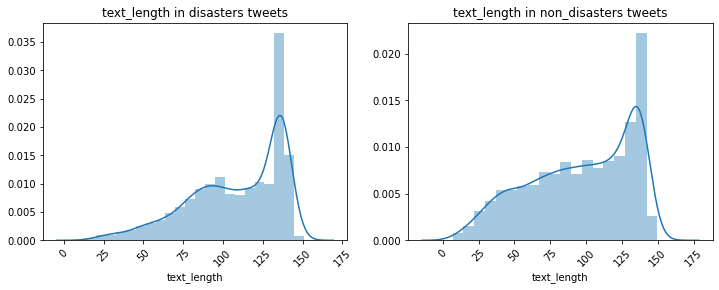

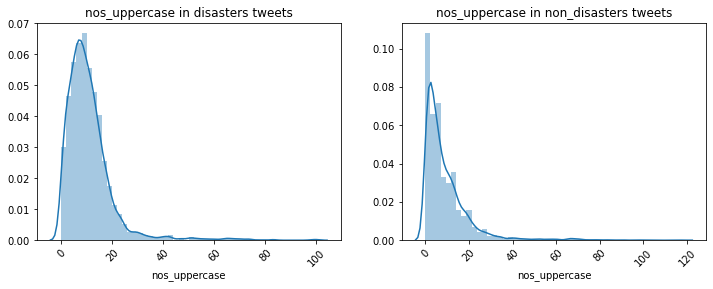

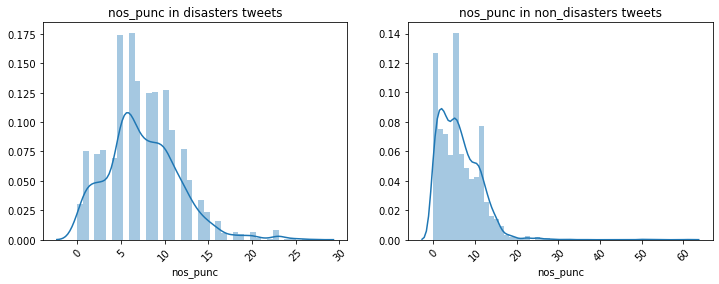

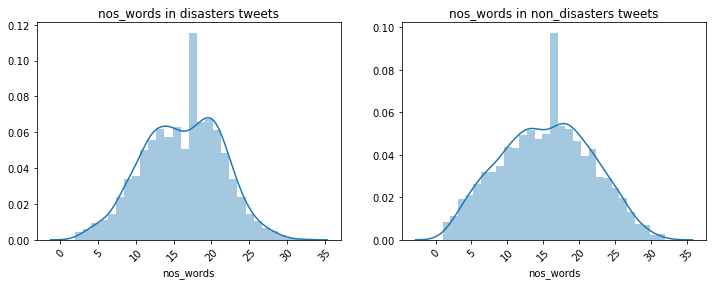

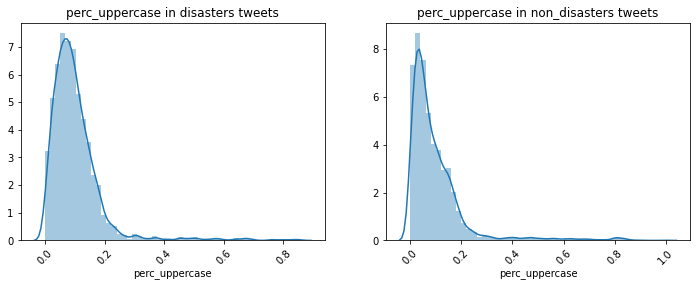

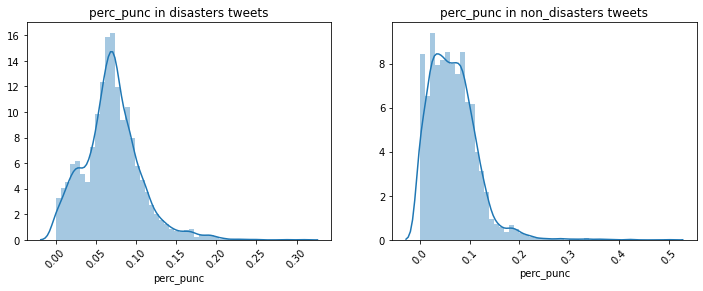

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


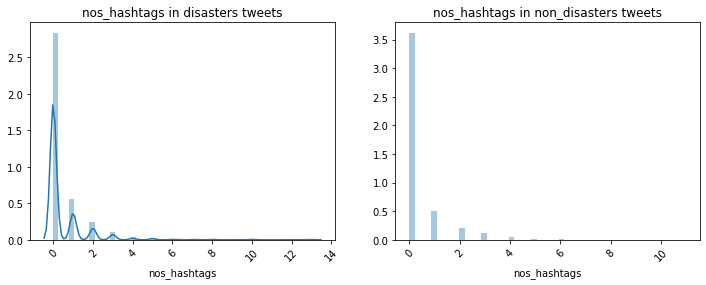

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


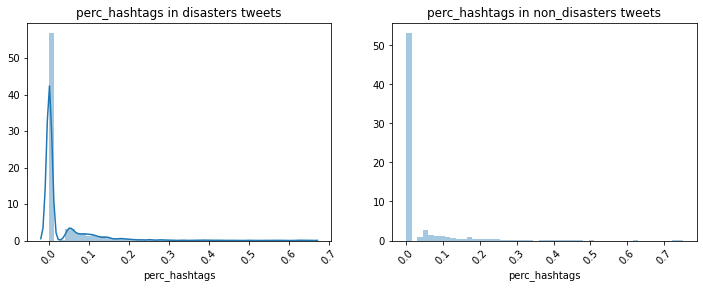

In [40]:
#apply the visualise_distplt function for each numeric feature
for col in ['text_length', 'nos_uppercase', 'nos_punc',
       'nos_words', 'perc_uppercase', 'perc_punc', 'nos_hashtags','perc_hashtags']:
    visualise_distplt(train,col,'target')

### Data cleaning of text

build the data cleaning function of text

In [22]:
#extend the stopwords with the list of words below
stpwrd.extend(['...','wa','ha','via',"'s",'amp'])

In [23]:
#a function to clean the text
def clean_text_(text,stemmer):
    #remove regex
    regexs = ["(http|www)(\S+)", #remove URL
              r'(@.+?)\s', #remove twitter usernames 
                  r'\d+', #remove numbers
                  r'(//t.co/.+?)\s', #remove twitter shortened URLs
              r'#(\w+)', #remove hashtags
              r'[^\x00-\x7F]+' #remove non_english characters
             ]
    for regex in regexs:
        text=re.sub(regex,"",text.lower())
    #expand the contractions
    words=text.lower().split()
    words=[contractions.fix(word) for word in words]
    text=" ".join(words)
    #tokenize text
    words=word_tokenize(text.lower())
    #stem or lamatize the tokens
    words=[stemmer(word) for word in words]
    #remove stopwords and punctuation
    words=[word for word in words if word not in stpwrd]
    words=[word for word in words if word not in punc]
    text=" ".join(words)
    return text

In [44]:
# example on cleaning function
text="The website is http.www.yahoo.com. Go check it. There are 13,000 days"
text=clean_text_(text,stemmer=lemmatizer.lemmatize)
text

'website go check day'

In [41]:
sample=train[['text']].sample(20)

In [45]:
sample['clean_text']=sample['text'].apply(clean_text_,stemmer=lemmatizer.lemmatize)

In [49]:
sample.to_csv('sample.csv',index=False)

In [28]:
#apply cleaning text function
train['clean_text']=train['text'].apply(clean_text_,stemmer=lemmatizer.lemmatize)

The data after extracting useful features and applying cleaning text function

In [51]:
train.head()

,id,text,target,text_length,nos_uppercase,nos_punc,nos_words,perc_uppercase,perc_punc,hashtags,nos_hashtags,perc_hashtags,clean_text
0,1,Our Deeds are the Reason of this #earthquake M...,1,69,10,1,13,0.144928,0.014493,earthquake,1,0.076923,deed reason may allah forgive u
1,4,Forest fire near La Ronge Sask. Canada,1,38,5,1,7,0.131579,0.026316,,0,0.000000,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,133,2,3,22,0.015038,0.022556,,0,0.000000,resident asked 'shelter place notified officer...
3,6,"13,000 people receive #wildfires evacuation or...",1,65,1,2,8,0.015385,0.030769,wildfires,1,0.125000,people receive evacuation order california
4,7,Just got sent this photo from Ruby #Alaska as ...,1,88,3,2,16,0.034091,0.022727,alaska wildfires,2,0.125000,got sent photo ruby smoke pours school


### Wordcloud of cleaned text and hashtags

created the wordclouds of cleaned text and hashtags in disaster tweet and non-disaster tweet 

In [26]:
#a function to create wordcloud of cleaned text/hashtags in disaster/non-diasaster tweets
#if_disaster (1: select disaster tweet, 0: select non-disaster tweet)
def create_wordcloud(df,col,if_disasters,width=600, height=300, max_words=100,sizes=(20,17),save=False):
    counts = Counter()
    data=df[df['target']==if_disasters][col]
    data.apply(lambda text:word_tokenize(text)).apply(counts.update)
    if if_disasters:
        background_color='Black'
        colormap='Dark2'
    else:
        background_color='white'
        colormap='rainbow'
    wc = WordCloud(width=width, height=height, max_words=max_words,background_color=background_color,colormap=colormap)\
    .generate_from_frequencies(counts)
    plt.figure(figsize=sizes)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    if save:
        plt.savefig(f'{if_disasters}_{col}_wordcloud.png')
    plt.show()

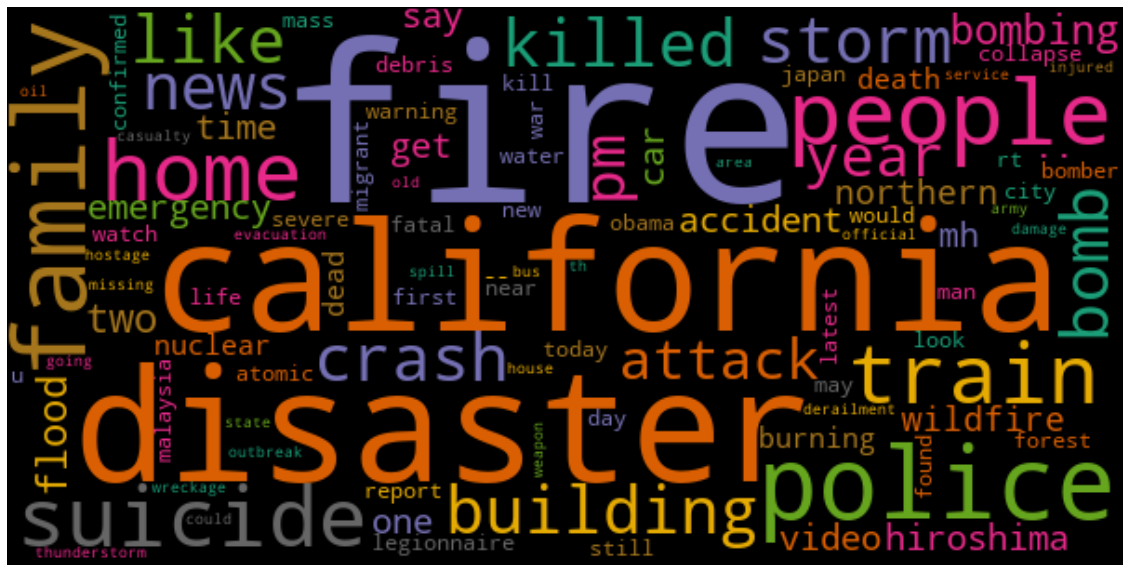

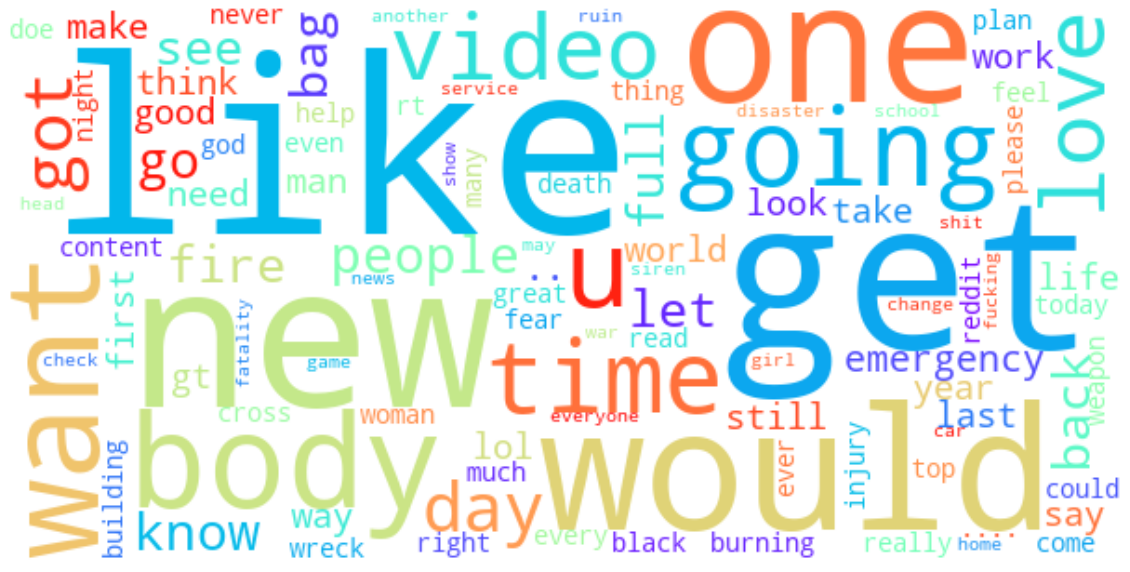

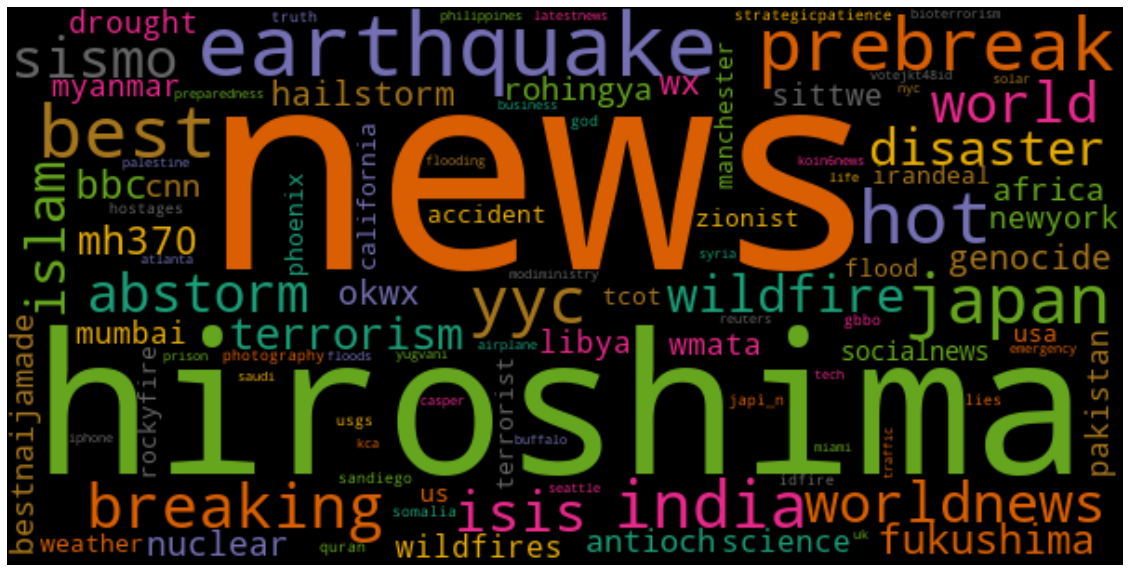

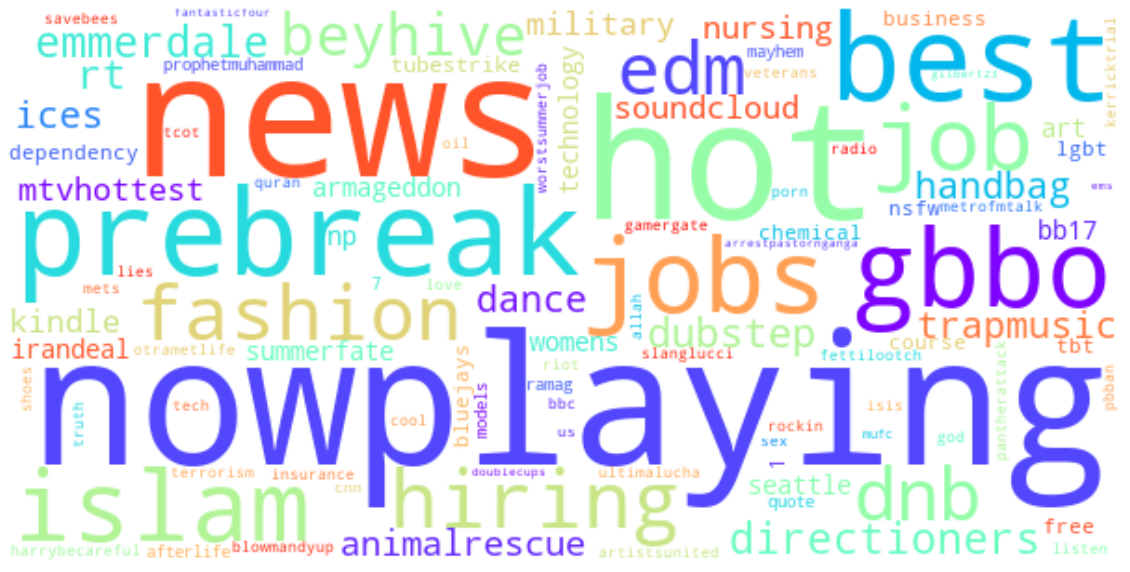

In [29]:
for col in ['clean_text','hashtags']:
    for if_disaster in [1,0]:
        create_wordcloud(train,col,if_disaster)

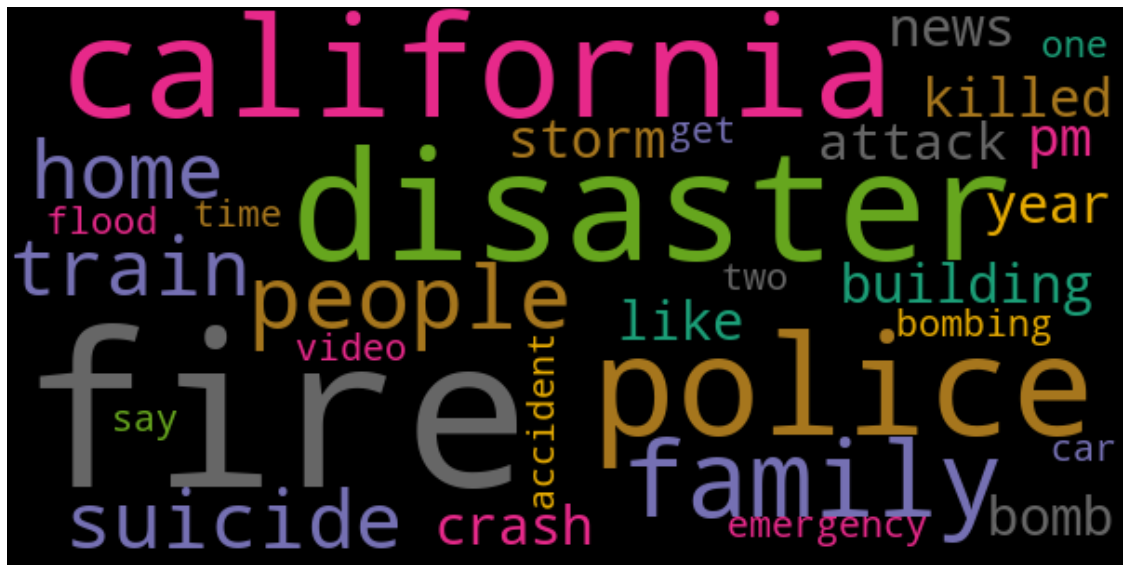

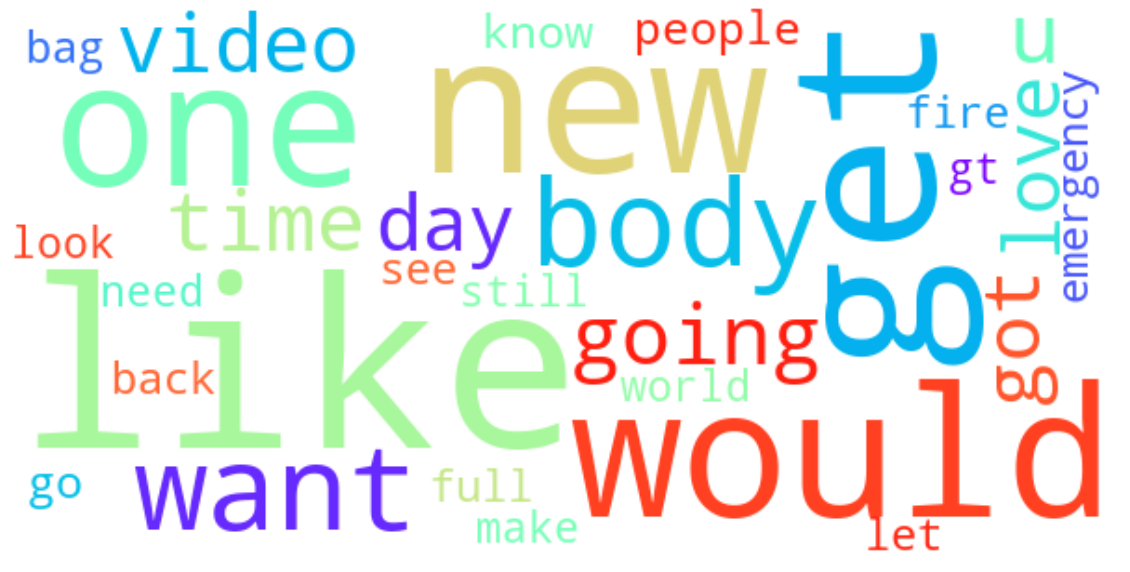

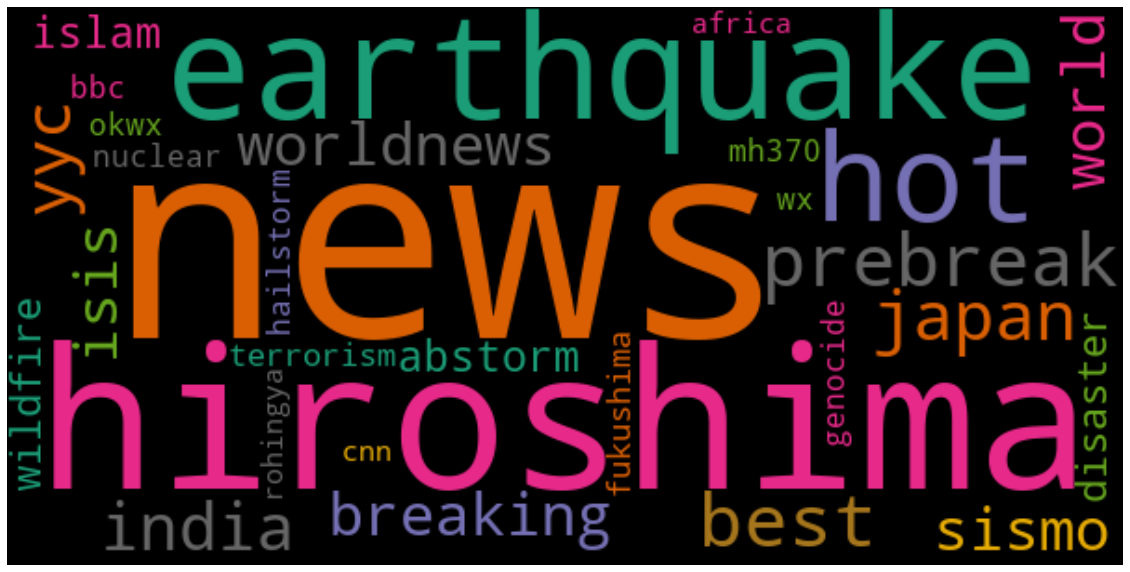

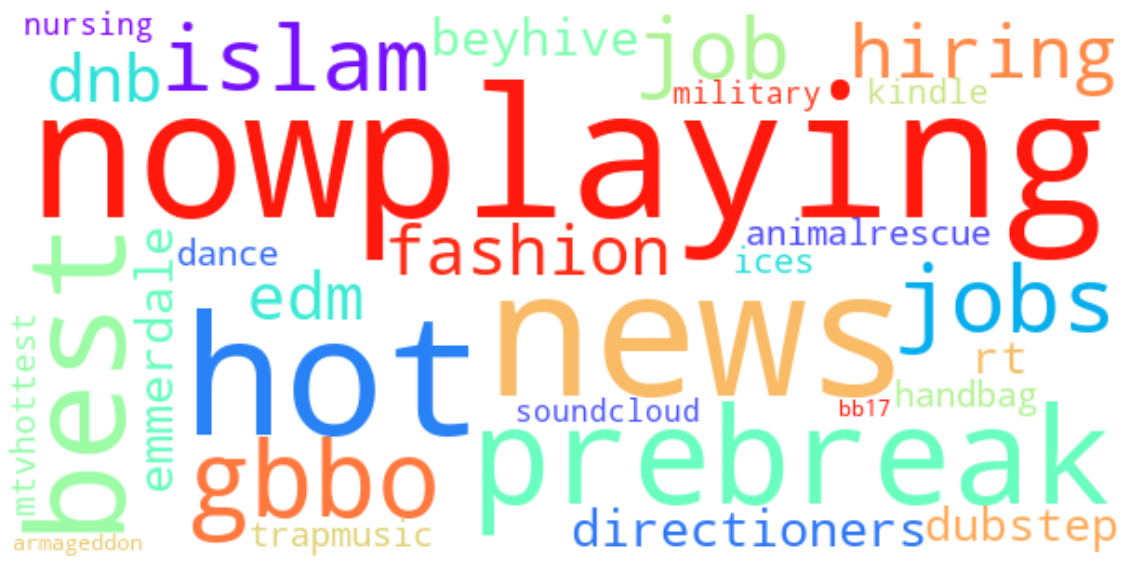

In [62]:
for col in ['clean_text','hashtags']:
    for if_disaster in [1,0]:
        create_wordcloud(train,col,if_disaster,save=True)

In [63]:
train.head()

,id,text,target,text_length,nos_uppercase,nos_punc,nos_words,perc_uppercase,perc_punc,hashtags,nos_hashtags,perc_hashtags,clean_text
0,1,Our Deeds are the Reason of this #earthquake M...,1,69,10,1,13,0.144928,0.014493,earthquake,1,0.076923,deed reason may allah forgive u
1,4,Forest fire near La Ronge Sask. Canada,1,38,5,1,7,0.131579,0.026316,,0,0.000000,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,133,2,3,22,0.015038,0.022556,,0,0.000000,resident asked 'shelter place notified officer...
3,6,"13,000 people receive #wildfires evacuation or...",1,65,1,2,8,0.015385,0.030769,wildfires,1,0.125000,people receive evacuation order california
4,7,Just got sent this photo from Ruby #Alaska as ...,1,88,3,2,16,0.034091,0.022727,alaska wildfires,2,0.125000,got sent photo ruby smoke pours school


### Output cleaned csv file

output the csv file of cleaned data for modelling

In [64]:
train.to_csv('train_cleaned.csv',index=False)